### Make initial conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.backends.backend_pdf
import gsw
import sys
# sys.path.append('/users/birgal/')
sys.path.append('/home/birgal/Documents/antarctic/analysis/')
from nemo_python.interpolation import interp_latlon_cf

In [90]:
#  File locations on laptop:
folder_SOSE = '/home/birgal/Documents/antarctic/data/B-SOSE/'
folder_BC   = '/home/birgal/Documents/antarctic/analysis/boundary-conditions/observational/'
folder_NEMO = '/home/birgal/Documents/antarctic/data/bathymetry/'

# Load files:
nemo = xr.open_dataset(f'{folder_NEMO}coordinates_AIS.nc').squeeze()
nemo_mask = xr.open_dataset(f'{folder_NEMO}mesh_mask-20231025.nc')
sose      = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m01.nc')
domcfg    = xr.open_dataset(f'{folder_NEMO}domain_cfg-20231025.nc')

nemo_depths = mesh.nav_lev.values

#### Functions

In [72]:
dataset = 'SOSE'

if dataset == 'SOSE':
    name_remapping = {'XC':'lon', 'YC':'lat', 'Z':'depth'}
    
    # Read temperature and salinity from January as a single dataset, and slice to latitude range that I want to interpolate to reduce size
    SOSE_salt = xr.open_dataset(f'/home/birgal/Documents/antarctic/data/B-SOSE/SALT_climatology_m01.nc').rename(name_remapping).sel(lat=slice(-90, -48))
    SOSE_temp = xr.open_dataset(f'/home/birgal/Documents/antarctic/data/B-SOSE/THETA_climatology_m01.nc').rename(name_remapping).sel(lat=slice(-90, -48))

    # For SOSE, convert longitudes from 0-360 to -180 to 180 
    SOSE_temp['lon'] = xr.where(SOSE_temp.lon  > 180, SOSE_temp.lon - 360, SOSE_temp.lon)
    SOSE_salt['lon'] = xr.where(SOSE_salt.lon  > 180, SOSE_salt.lon - 360, SOSE_salt.lon)
    SOSE_temp = SOSE_temp.sortby('lon'); SOSE_salt = SOSE_salt.sortby('lon')
    
    # Convert to TEOS10
    # Need pressure in dbar at every 3D point: approx depth in m
    SOSE_press = np.abs(xr.broadcast(SOSE_temp['depth'], SOSE_temp['THETA'])[0])
    # Also need 3D lat and lon
    SOSE_lon = xr.broadcast(SOSE_temp['lon'], SOSE_temp['THETA'])[0]
    SOSE_lat = xr.broadcast(SOSE_temp['lat'], SOSE_temp['THETA'])[0]
    # Get absolute salinity
    SOSE_SA  = gsw.SA_from_SP(SOSE_salt['SALT'], SOSE_press, SOSE_lon, SOSE_lat)
    # Get conservative temperature
    SOSE_CT  = gsw.CT_from_t(SOSE_SA, SOSE_temp['THETA'], SOSE_press)
    # Now wrap up into a new Dataset
    source = xr.Dataset({'lon':SOSE_temp['lon'], 'lat':SOSE_temp['lat'], 
                         'THETA': xr.where(source.maskC==1, SOSE_CT.isel(depth=0), np.nan)}) #, 'salt':SOSE_SA.isel(depth=0)})

    # print('Building grids')
    # model_grid = grid_check_split(grid_path, 180)
    # sose_grid  = SOSEGrid(sose_grid_path, model_grid=model_grid, split=180)
    # print('Building mask for SOSE points to fill')
    # fill, model_cavity = get_fill_mask(sose_grid, model_grid)

    interp_src = interpolate_IC(source, nemo)
    # process_ini_field(woa_data, woa_grid.mask, fill, woa_grid, model_grid, dim, var_names[n], out_file_paths[n], missing_cavities=False, prec=prec)

In [115]:
source_mask = (sose.maskC == 0)
nemo_ocn    = (nemo_mask.tmask.isel(time_counter=0, nav_lev=0) != 0)

# in ocean cells that have NaN value, fill with 1 for now
# xr.where(nemo_ocn and interp_src.THETA == 0, )
mask_to_fill = xr.where(np.isnan(interp_src.THETA.values)*nemo_ocn, 1, 0) # regions that will need to be filled
# could use numpy masked edges in subsequent loops to fill

In [107]:
theta_extended = extend_into_mask(theta_filled.values) # doesn't change any of the values

In [121]:
(mask_to_fill==1)
# for each value in the mask, select the 9 closest points from the interpolated theta and take the average of those and fill the value

<xarray.DataArray 'tmask' (y: 453, x: 1440)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    nav_lev       float32 0.4921
    time_counter  float32 0.0
Dimensions without coordinates: y, x

In [133]:
interp_src_tofill = xr.where(np.isnan(interp_src.THETA.values)*nemo_ocn, 1000, interp_src.THETA)

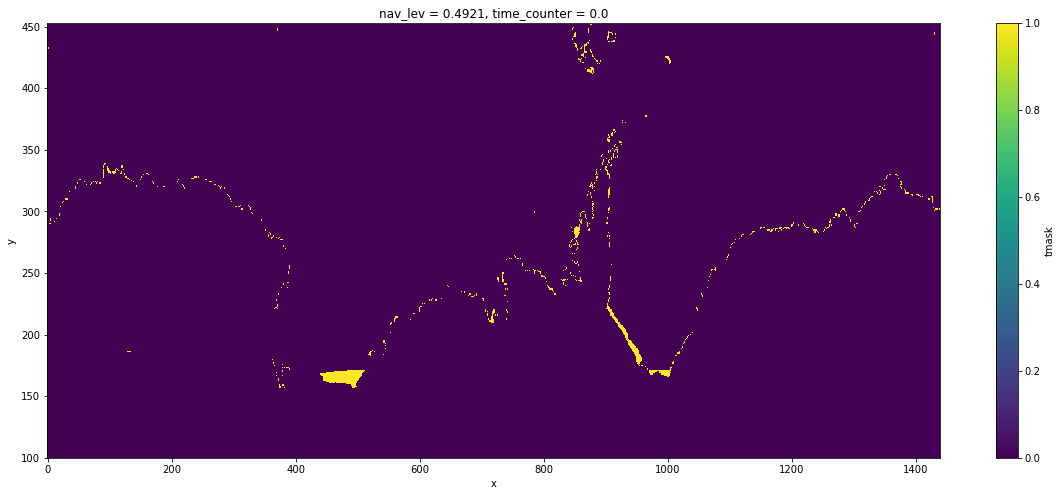

In [123]:
theta_filled.plot(ylim=(100,453), figsize=(20,8))

In [128]:
# Consider filling with machine learning
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
import sklearn.impute as ski

In [144]:
ski.KNNImputer(interp_src_tofill, missing_values=1000)

TypeError: KNNImputer.__init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

(100.0, 453.0)

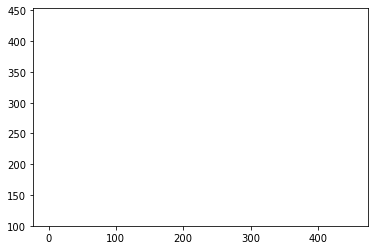

In [109]:
plt.plot(theta_extended)
plt.ylim(100,453)

In [29]:
def interpolate_IC(source, nemo):
    # Steps:
    # - interpolate source file to nemo grid for each horizontal slice over all depth levels 
    # - fill areas in cavities with nearest neighbour
    
    # Land mask:
    # source_mask = (sose_grid.maskC == 0)
    # print('Building mask for SOSE points to fill')
    # fill, model_cavity = get_fill_mask(sose_grid, model_grid)

    # Interpolate slices of depth levels along lat-lon
    data_interp = interp_latlon_cf(source, nemo, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')

    # 
    # source_data = discard_and_fill(source, source_mask[0,:], fill[0,:], use_3d=False, missing_val=missing_val)
    
    return data_interp

In [15]:
# Given data on a 3D grid (or 2D if you set use_3d=False), throw away any points indicated by the "discard" boolean mask (i.e. fill them with missing_val), 
# and then extrapolate into any points indicated by the "fill" boolean mask (by calling extend_into_mask as many times as needed).
def discard_and_fill (data, discard, fill, missing_val=-9999, use_1d=False, use_3d=True, preference='horizontal', log=True):

    # First throw away the points we don't trust
    data[discard] = missing_val
    # Now fill the values we need to fill
    num_missing = np.count_nonzero((data==missing_val)*fill)
    while num_missing > 0:
        if log:
            print('......' + str(num_missing) + ' points to fill')
        data            = extend_into_mask(data, missing_val=missing_val, use_1d=use_1d, use_3d=use_3d, preference=preference)
        num_missing_old = num_missing
        num_missing     = np.count_nonzero((data==missing_val)*fill)
        
        if num_missing == num_missing_old:
            # There are some disconnected regions. This can happen with coupling sometimes. Try using more iterations of extend_into_mask.
            for iters in range(2, 100):
                data = extend_into_mask(data, missing_val=missing_val, use_1d=use_1d, use_3d=use_3d, preference=preference, num_iters=iters)
                num_missing_old = num_missing
                num_missing = np.count_nonzero((data==missing_val)*fill)
    return data

# Given an array with missing values, extend the data into the mask by setting missing values to the average of their non-missing neighbours, and repeating as many times as the user wants.
# If "data" is a regular array with specific missing values, set missing_val (default -9999). If "data" is a MaskedArray, set masked=True instead.
# Setting use_3d=True indicates this is a 3D array, and where there are no valid neighbours on the 2D plane, neighbours above and below should be used.
# Setting preference='vertical' (instead of default 'horizontal') indicates that if use_3d=True, vertical neighbours should be preferenced over horizontal ones.
# Setting use_1d=True indicates this is a 1D array.
def extend_into_mask (data, missing_val=-9999, masked=False, use_1d=False, use_3d=False, preference='horizontal', num_iters=1):

    if missing_val != -9999 and masked:
        print("Error (extend_into_mask): can't set a missing value for a masked array")
        sys.exit()
    if use_1d and use_3d:
        print("Error (extend_into_mask): can't have use_1d and use_3d at the same time")
        sys.exit()
    if use_3d and preference not in ['horizontal', 'vertical']:
        print('Error (extend_into_mask): invalid preference ' + preference)

    if masked:
        # MaskedArrays will mess up the extending
        # Unmask the array and fill the mask with missing values
        data_unmasked = data.data
        data_unmasked[data.mask] = missing_val
        data = data_unmasked

    for iter in range(num_iters):
        # Find the neighbours of each point, whether or not they are missing, and how many non-missing neighbours there are.
        # Then choose the points that can be filled.
        # Then set them to the average of their non-missing neighbours.
        if use_1d:
            # Just consider horizontal neighbours in one direction
            data_w, data_e, valid_w, valid_e, num_valid_neighbours = neighbours(data, missing_val=missing_val, use_1d=True)
            index = (data == missing_val)*(num_valid_neighbours > 0)
            data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index])/num_valid_neighbours[index]
        elif use_3d and preference == 'vertical':
            # Consider vertical neighbours
            data_d, data_u, valid_d, valid_u, num_valid_neighbours = neighbours_z(data, missing_val=missing_val)
            index = (data == missing_val)*(num_valid_neighbours > 0)
            data[index] = (data_u[index]*valid_u[index] + data_d[index]*valid_d[index])/num_valid_neighbours[index]
        else:
            # Consider horizontal neighbours in both directions
            data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours = neighbours(data, missing_val=missing_val)
            index = (data == missing_val)*(num_valid_neighbours > 0)
            data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index] + data_s[index]*valid_s[index] + data_n[index]*valid_n[index])/num_valid_neighbours[index]
        if use_3d:
            # Consider the other dimension(s). Find the points that haven't already been filled based on the first dimension(s) we checked, but could be filled now.
            if preference == 'vertical':
                # Look for horizontal neighbours
                data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours_new = neighbours(data, missing_val=missing_val)
                index = (data == missing_val)*(num_valid_neighbours == 0)*(num_valid_neighbours_new > 0)
                data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index] + data_s[index]*valid_s[index] + data_n[index]*valid_n[index])/num_valid_neighbours_new[index]
            elif preference == 'horizontal':
                # Look for vertical neighbours
                data_d, data_u, valid_d, valid_u, num_valid_neighbours_new = neighbours_z(data, missing_val=missing_val)
                index = (data == missing_val)*(num_valid_neighbours == 0)*(num_valid_neighbours_new > 0)
                data[index] = (data_u[index]*valid_u[index] + data_d[index]*valid_d[index])/num_valid_neighbours_new[index]
                
    if masked:
        # Remask the MaskedArray
        data = ma.masked_where(data==missing_val, data)

    return data    

In [14]:
# Finds the value of the given array to the west, east, south, north of every point, as well as which neighbours are non-missing, and how many neighbours are non-missing.
# Can also do 1D arrays (so just neighbours to the left and right) if you pass use_1d=True.
def neighbours (data, missing_val=-9999, use_1d=False):

    # Find the value to the west, east, south, north of every point
    # Just copy the boundaries
    data_w          = np.empty(data.shape)
    data_w[...,1:]  = data[...,:-1]
    data_w[...,0]   = data[...,0]
    data_e          = np.empty(data.shape)
    data_e[...,:-1] = data[...,1:]
    data_e[...,-1]  = data[...,-1]
    if not use_1d:
        data_s            = np.empty(data.shape)
        data_s[...,1:,:]  = data[...,:-1,:]
        data_s[...,0,:]   = data[...,0,:]
        data_n            = np.empty(data.shape)
        data_n[...,:-1,:] = data[...,1:,:]
        data_n[...,-1,:]  = data[...,-1,:]     
        
    # Arrays of 1s and 0s indicating whether these neighbours are non-missing
    valid_w = (data_w != missing_val).astype(float)
    valid_e = (data_e != missing_val).astype(float)
    if use_1d:
        # Number of valid neighoburs of each point
        num_valid_neighbours = valid_w + valid_e
        # Finished
        return data_w, data_e, valid_w, valid_e, num_valid_neighbours
        
    valid_s = (data_s != missing_val).astype(float)
    valid_n = (data_n != missing_val).astype(float)
    
    num_valid_neighbours = valid_w + valid_e + valid_s + valid_n
    
    return data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours


# Like the neighbours function, but in the vertical dimension: neighbours above and below
def neighbours_z (data, missing_val=-9999):

    data_u              = np.empty(data.shape)
    data_u[...,1:,:,:]  = data[...,:-1,:,:]
    data_u[...,0,:,:]   = data[...,0,:,:]
    
    data_d              = np.empty(data.shape)
    data_d[...,:-1,:,:] = data[...,1:,:,:]
    data_d[...,-1,:,:]  = data[...,-1,:,:]
    valid_u = (data_u  != missing_val).astype(float)
    valid_d = (data_d  != missing_val).astype(float)
    
    num_valid_neighbours_z = valid_u + valid_d
    
    return data_u, data_d, valid_u, valid_d, num_valid_neighbours_z

# Helper function for initial conditions: figure out which points on the source grid will be needed for interpolation. 
# Does not include ice shelf cavities, unless missing_cavities=False.
def get_fill_mask (source_grid, model_grid, missing_cavities=True):

    # from .interpolation import interp_reg

    # Find open cells according to the model, interpolated to source grid
    model_open = np.ceil(interp_reg(model_grid, source_grid, np.ceil(model_grid.hfac), fill_value=0))
    if missing_cavities:    
        # Find ice shelf cavity points according to model, interpolated to source grid
        model_cavity = np.ceil(interp_reg(model_grid, source_grid, xy_to_xyz(model_grid.ice_mask, model_grid), fill_value=0)).astype(bool)
        # Select open, non-cavity cells
        fill = model_open*np.invert(model_cavity)
    else:
        fill = model_open
    # Extend into the mask a few times to make sure there are no artifacts near the coast
    fill = extend_into_mask(fill, missing_val=0, use_3d=True, num_iters=3)
    
    if missing_cavities:
        return fill, model_cavity
    else:
        return fill

In [ ]:
# Helper function for initial conditions: process and interpolate a field from the source grid to the model grid, and write to file (binary plus NetCDF if needed).
def process_ini_field (source_data, source_mask, fill, 
                       source_grid, model_grid, dim, field_name, out_file, 
                       missing_cavities=True, model_cavity=None, cavity_value=None, 
                       regular=True, nc_out=None, ncfile=None, prec=64, missing_val=-9999):

    from .interpolation import interp_reg, interp_nonreg
        
    print('...extrapolating into missing regions')
    if dim == 3:
        source_data = discard_and_fill(source_data, source_mask, fill, missing_val=missing_val)
        if missing_cavities:
            source_data[model_cavity] = cavity_value
    else:
        # Just the surface layer
        source_data = discard_and_fill(source_data, source_mask[0,:], fill[0,:], use_3d=False, missing_val=missing_val)

    print('...interpolating to model grid')
    if regular:
        data_interp = interp_reg(source_grid, model_grid, source_data, dim=dim)
    else:
        data_interp = interp_nonreg(source_grid, model_grid, source_data, dim=dim, fill_value=missing_val)
    if dim==3 and missing_cavities:
        # Fill the cavities with constant values again, because there may be artifacts near the grounding line (cavity points not included in extend_into_mask call in get_fill_mask)
        data_interp[xy_to_xyz(model_grid.ice_mask, model_grid)] = cavity_value
        
    # Fill the land mask with zeros
    if dim == 3:
        data_interp[model_grid.hfac==0] = 0
    else:
        data_interp[model_grid.hfac[0,:]==0] = 0


# Create initial conditions for temperature, salinity, sea ice area, and sea ice thickness using the SOSE monthly climatology for January. Ice shelf cavities will be filled with constant temperature and salinity.

# Arguments:
# grid_path: path to directory containing MITgcm binary grid files
# sose_dir: directory containing SOSE monthly climatologies and grid/ subdirectory (available on Scihub at /data/oceans_input/raw_input_data/SOSE_monthly_climatology)
# output_dir: directory to save the binary MITgcm initial conditions files (binary)

# Optional keyword arguments:
# bsose: set to True if it's the BSOSE version, including SIhsnow and saved in NetCDF files.
# nc_out: path to a NetCDF file to save the initial conditions in, so you can easily check that they look okay
# constant_t, constant_s: temperature and salinity to fill ice shelf cavities with (default -1.9 C and 34.4 psu)
# split: longitude to split the SOSE grid at. Must be 180 (if your domain includes 0E; default) or 0 (if your domain includes 180E). If your domain is circumpolar (i.e. includes both 0E and 180E), try either and hope for the best. You might have points falling in the gap between SOSE's periodic boundary, in which case you'll have to write a few patches to wrap the SOSE data around the boundary (do this in the SOSEGrid class in grid.py).
# prec: precision to write binary files (64 or 32, must match readBinaryPrec in "data" namelist)
# skip_ts: boolean indicating to skip temperature and salinity (default False)
            sose_data = sose_grid.read_field(in_file, 'xyt', var_name=fields[n], fill_value=0)[0,:]
        process_ini_field(sose_data, sose_mask, fill, sose_grid, model_grid, dim[n], fields[n], out_file, model_cavity=model_cavity, cavity_value=constant_value[n], nc_out=nc_out, ncfile=ncfile, prec=prec)